# Election Tweets Analysis

## Load Python Dependencies

In [1]:
import graphlab as gl
import re
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread
import pandas as pd

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1483927055.log


This non-commercial license of GraphLab Create for academic use is assigned to epigos@gmail.com and will expire on September 25, 2017.


### Load and clean tweets

In [2]:
raw_tweets = gl.SFrame('data/tweets.csv')

Finished parsing file /Users/philip/devel/ml/ghana_elections/data/tweets.csv

Parsing completed. Parsed 100 lines in 0.204835 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,int,int,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/philip/devel/ml/ghana_elections/data/tweets.csv

Parsing completed. Parsed 65499 lines in 0.250371 secs.

In [25]:
# cleanup scripts
def cleanup_text(value):
    """Cleanup tweets by removing 'retweeted', stopwords and other characters"""
    output = []
    value = re.sub(r'((retweeted))', '', value, flags=re.I)
    value = re.sub(r'[^\w\s]+', ' ', value)
    for word in value.split():
        if len(word) > 2 and word not in gl.text_analytics.stopwords():
            output.append(word.strip())
    return ' '.join(output)

In [26]:
raw_tweets['clean_text'] = raw_tweets['text'].apply(cleanup_text)

In [27]:
tweets = raw_tweets[raw_tweets['clean_text'] != '']

In [28]:
tweets.show()

Canvas is accessible via web browser at the URL: http://localhost:51283/index.html
Opening Canvas in default web browser.


# Wordcloud

In [60]:
ghana_map_mask = imread('./assets/ghana_map.png')
text = ' '.join(tweets['clean_text'])
wordcloud = WordCloud(
    font_path='./assets/RobotoDraft-Regular.ttf',
    stopwords=STOPWORDS,
    background_color='white',
    max_words=500,
    mask=ghana_map_mask,
    random_state=90
).generate(text)

## save word cloud as image

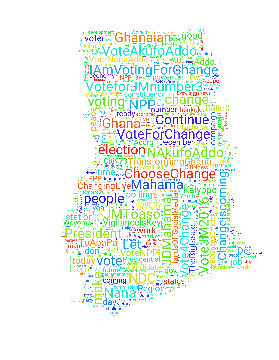

In [61]:
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./tweet_cloud.png', dpi=600)
plt.show()

# Predict sentiments of tweets

In [100]:
sentiment_model = gl.sentiment_analysis.create(tweets, features=['clean_text'])

In [30]:
tweets['sentiment_score'] = sentiment_model.predict(tweets)

In [31]:
def get_sentiment_from_score(value):
    if value > 0.65:
        return 'positive'
    elif value < 0.45:
        return 'negative'
    return 'neutral'

In [32]:
tweets['sentiment'] = tweets['sentiment_score'].apply(get_sentiment_from_score)

In [33]:
tweets.show()

Canvas is accessible via web browser at the URL: http://localhost:51283/index.html
Opening Canvas in default web browser.


# Detects emotions in tweets

### Load NRC emotion lexicons

In [34]:
lexicons = gl.SFrame('data/emotion_lexicons.csv')
topics = lexicons['emotion'].unique()

Finished parsing file /Users/philip/devel/ml/ghana_elections/data/emotion_lexicons.csv

Parsing completed. Parsed 100 lines in 0.028386 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/philip/devel/ml/ghana_elections/data/emotion_lexicons.csv

Parsing completed. Parsed 4463 lines in 0.012209 secs.

In [35]:
lexicons

emotion,word
trust,abacus
fear,abandon
anger,abandoned
anger,abandonment
trust,abbot
fear,abduction
disgust,aberration
anger,abhor
anger,abhorrent
disgust,abject


### Convert lexicons from str to int type

In [36]:
topics.sort()
map_topics = {}
for k, v in enumerate(topics.sort()):
    map_topics[v] = k


def get_emotion(value):
    for k, v in map_topics.items():
        if v == value:
            return k

In [37]:
lexicons['emotion'] = lexicons['emotion'].apply(lambda k: map_topics[k])

### Perform word count on tweets

In [38]:
tweets['word_count'] = gl.text_analytics.count_words(tweets['clean_text'])

### Load emotion model

In [39]:
emotion_model = gl.load_model('models/emotion_model')

In [40]:
tweets['emotion_score'] = emotion_model.predict(tweets['word_count'])
tweets['emotion'] = tweets['emotion_score'].apply(get_emotion)
tweets['emotion'].show()

Canvas is accessible via web browser at the URL: http://localhost:51283/index.html
Opening Canvas in default web browser.


# Visualization of Analysis

## Top tweets

In [41]:
top_tweets = tweets.sort('score', ascending=False)[:10]
ts = top_tweets[['timestamp', 'text', 'username', 'hashtag', 'score']]
top_tweets_df = ts.to_dataframe()
top_tweets_df.reset_index(drop=True, inplace=True)
top_tweets_df.index += 1
top_tweets_df

,timestamp,text,username,hashtag,score
1,2016-12-06 10:52:51,Voting won t put food on your table but it will determine what food is put on your table,ameyaw112,GhanaDecides,735
2,2016-12-05 14:31:32,Ahead of 5 quirky things you might NOT know about Ghanaian elections Or do you,BBCAfrica,GhanaDecides,719
3,2016-12-07 10:45:01,As today we re wishing our Ghanaian followers a peaceful election Share your IVoted pics using the hashtag CNNGhanaWeek,CNNAfrica,GhanaDecides,620
4,2016-12-02 14:00:02,Did you know there are more mobile phones than people in Ghana CNNGhanaWeek,CNNAfrica,GhanaDecides,606
5,2016-12-07 15:00:00,Voting in Jaman North Brong Ahafo is going on TODAY If you are in line before 5pm YOU WILL BE ALLOWED TO VOTE VOTEFORCHANGE,NAkufoAddo,VoteForChange,479
6,2016-12-07 06:50:48,Silent Majority Vocal Minority or whoever you say you are it s time to be heard through your thumb ElectionHQ Adentan,TheIsraelLaryea,GhanaDecides,454
7,2016-11-27 14:43:57,Everywhere I go I meet Ghanaians who are calling for change They are standing up for their future ChooseChange IAmVotingForChange,NAkufoAddo,ChooseChange,453
8,2016-12-05 09:12:24,Hello friends the date of destiny is approaching Wednesday presents an opportunity to make history and VoteForChange,MBawumia,VoteForChange,431
9,2016-11-30 13:09:50,The man working for you Vote JDMahama Vote more jobs for the youth TransformingGhana ChangingLives,TransformingGh,TransformingGhana,409
10,2016-12-07 12:36:51,Governor elrufai is currently in Ghana Observing the Presidential and Parliamentary Elections,GovKaduna,GhanaDecides,392


## Top users

In [42]:
top_users = tweets.groupby(key_columns='username', 
                           operations={'Tweet Count': gl.aggregate.COUNT(), 
                                       'Tweet Score': gl.aggregate.SUM('score')}
                          )
top_users.rename({'username': 'Twitter Id'})
top_users = top_users[top_users['Tweet Count'] > top_users['Tweet Count'].mean()]

In [43]:
top_users['Avg Score Per Tweet'] = top_users['Tweet Score'] / top_users['Tweet Count']
top_users_df = top_users.to_dataframe()
top_users_df

,Twitter Id,Tweet Count,Tweet Score,Avg Score Per Tweet
0,OJSarpong,61,56,0.918033
1,Rosakum3,20,7,0.350000
2,atajohn6,31,11,0.354839
3,AStella2131,74,0,0.000000
4,PaakowEghan,12,32,2.666667
5,sYzirO1,16,10,0.625000
6,WarrenCFC,16,72,4.500000
7,ElectionNetwork,12,66,5.500000
8,Beekie75,35,10,0.285714
9,BBB_De_engineer,78,0,0.000000


### Based on Tweet Count

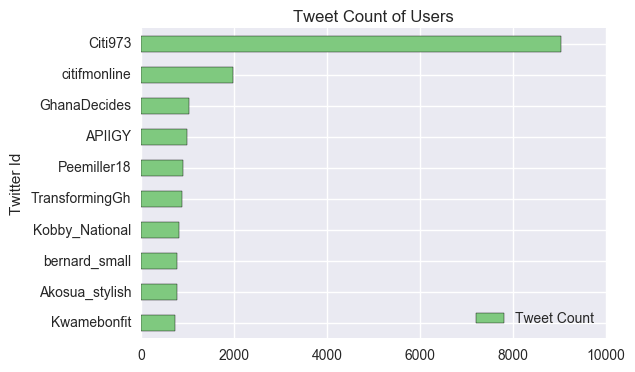

In [44]:
top_users_df = top_users_df.sort_values(by=['Tweet Count'], ascending=False)
top_users_df.reset_index(drop=True, inplace=True)
top_users_df.index += 1
users_count = top_users_df[:10]
users_count = users_count.sort_values('Tweet Count')
ax = users_count.plot(x='Twitter Id', y='Tweet Count', kind='barh', colormap='Accent', 
                          title='Tweet Count of Users', figsize=(6, 4))

In [45]:
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('plots/tweets_users_count.png', dpi=200)

### Based on Tweet Score

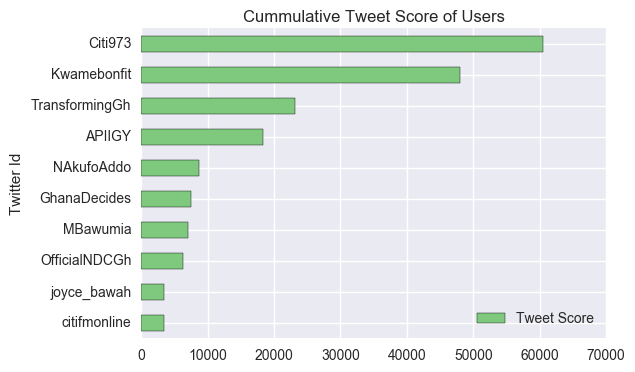

In [46]:
top_users_df = top_users_df.sort_values(by=['Tweet Score'], ascending=False)
top_users_df.reset_index(drop=True, inplace=True)
top_users_df.index += 1
users_score = top_users_df[:10]
users_score = users_score.sort_values('Tweet Score')
ax = users_score.plot(x='Twitter Id', y='Tweet Score', kind='barh', colormap='Accent', 
                          title='Cummulative Tweet Score of Users', figsize=(6, 4))

In [47]:
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('plots/tweets_users_score.png', dpi=200)

### Based on Avg Score Per Tweet

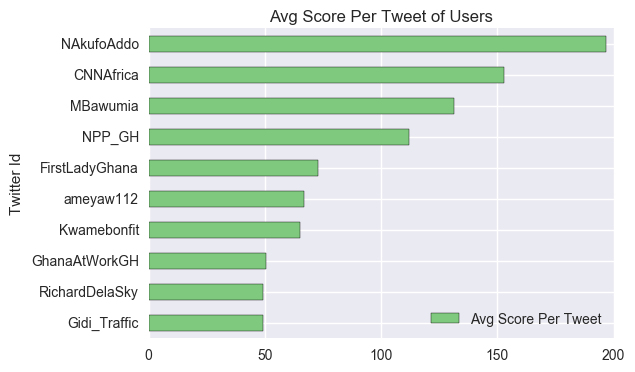

In [48]:
top_users_df = top_users_df.sort_values(by=['Avg Score Per Tweet'], ascending=False)
top_users_df.reset_index(drop=True, inplace=True)
top_users_df.index += 1
users_avg_score = top_users_df[:10]
users_avg_score = users_avg_score.sort_values('Avg Score Per Tweet')
ax = users_avg_score.plot(x='Twitter Id', y='Avg Score Per Tweet', kind='barh', colormap='Accent', 
                          title='Avg Score Per Tweet of Users', figsize=(6, 4))

In [49]:
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('plots/tweets_users_avg_score.png', dpi=200)

## Top hashtags

In [50]:
top_hashtags = tweets.groupby(key_columns='hashtag', 
                           operations={'Count': gl.aggregate.COUNT(), 
                                       'Score': gl.aggregate.SUM('score'),
                                       'Avg Score': gl.aggregate.MEAN('score')
                                      })
top_hashtags.rename({'hashtag': 'Hashtag'})
top_hashtags_df = top_hashtags.to_dataframe()
top_hashtags_df.sort_values('Avg Score', ascending=True, inplace=True)

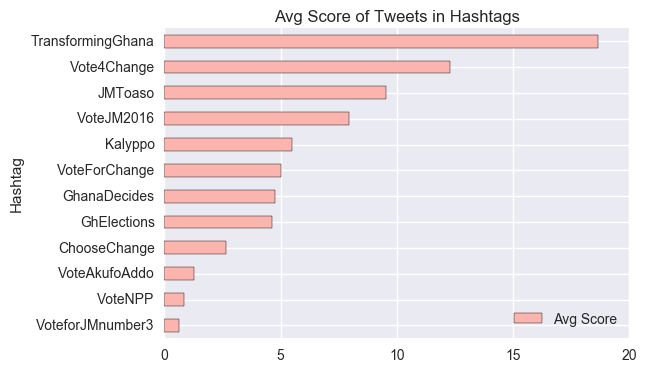

In [51]:
ax = top_hashtags_df.plot(x='Hashtag', y='Avg Score', kind='barh', colormap='Pastel1',
                    title='Avg Score of Tweets in Hashtags', figsize=(6, 4))

In [52]:
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('plots/tweets_hashtag_score.png', dpi=200)

## Sentiment Polarity

In [53]:
sentiments = tweets[['sentiment']].groupby(['sentiment'], [gl.aggregate.COUNT()])

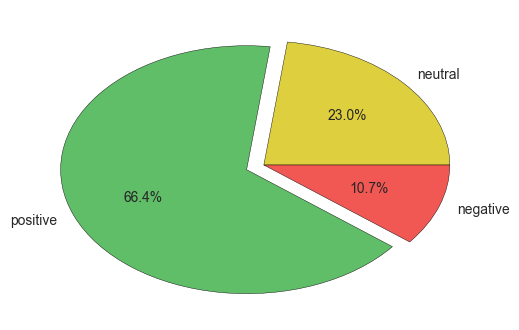

In [54]:
plt.pie(sentiments['Count'], labels=sentiments['sentiment'], 
        colors=['#DECF3F', '#60BD68', '#F15854'], explode = (0, 0.1, 0),
        autopct='%1.1f%%'
       )
plt.axis('off')
plt.savefig('plots/tweets_sentiment.png', dpi=300)
plt.show()

### Sentiment by hashtags

In [55]:
df_tweets = tweets.to_dataframe()

In [56]:
neg_tweets = tweets.filter_by('negative', column_name='sentiment')
neg_tweets = neg_tweets.groupby(['hashtag'], {'Negative Tweets': gl.aggregate.COUNT()})

In [57]:
pos_tweets = tweets.filter_by('positive', column_name='sentiment')
pos_tweets = pos_tweets.groupby(['hashtag'], {'Positive Tweets': gl.aggregate.COUNT()})

In [58]:
neu_tweets = tweets.filter_by('neutral', column_name='sentiment')
neu_tweets = neu_tweets.groupby(['hashtag'], {'Neutral Tweets': gl.aggregate.COUNT()})

In [59]:
pos_tweets.add_columns(neu_tweets[['Neutral Tweets']])
pos_tweets.add_columns(neg_tweets[['Negative Tweets']])

hashtag,Positive Tweets,Neutral Tweets,Negative Tweets
TransformingGhana,1007,144,75
JMToaso,6961,2669,586
VoteForChange,1560,893,338
VoteAkufoAddo,2099,722,369
GhanaDecides,6920,1317,955
VoteJM2016,1482,503,106
Vote4Change,9,10,1
Kalyppo,915,301,146
ChooseChange,1813,1025,559
GhElections,12006,2261,2875


In [60]:
hashtag_sentiment = pos_tweets.to_dataframe()

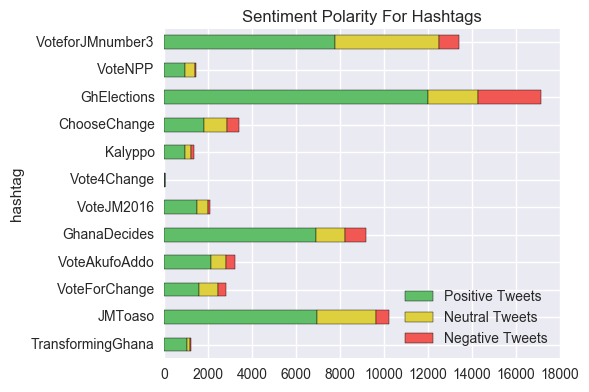

In [61]:
ax = hashtag_sentiment.plot.barh(x='hashtag', stacked='True',
                            color=['#60BD68', '#DECF3F', '#F15854'], 
                            title='Sentiment Polarity For Hashtags',
                                )
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('plots/tweets_hashtag_sentiment.png', dpi=200)

## Emotion displayed

In [62]:
emotions = tweets[['emotion']].groupby(['emotion'], [gl.aggregate.COUNT()])
df_emotions = emotions.to_dataframe()

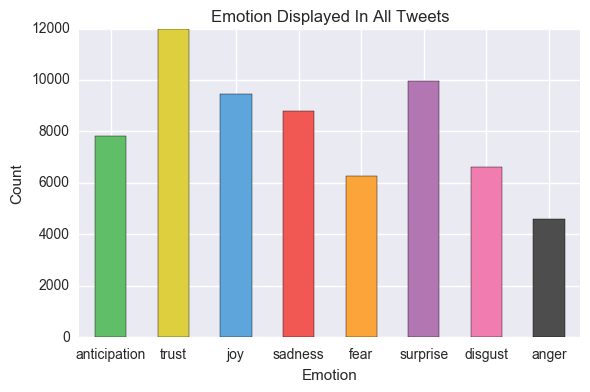

In [63]:
ax = df_emotions.plot.bar(x='emotion', color=['#60BD68', '#DECF3F', '#5DA5DA', '#F15854', '#FAA43A',
                                              '#B276B2', '#F17CB0', '#4D4D4D'
                                             ],
                          title='Emotion Displayed In All Tweets',
                          legend=False,rot=0
                        )
ax.set_ylabel("Count")
ax.set_xlabel("Emotion")
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('plots/tweets_emotions.png', dpi=200)

### Emotion displayed by Political Party

In [64]:
ndc = tweets.filter_by(['VoteforJMnumber3', 'Vote4JM', 'JMToaso', 'VoteJM2016', 'TransformingGhana', 'ChangingLives'], 
                       column_name='hashtag')
npp = tweets.filter_by(['VoteAkufoAddo', 'VoteNPP', 'VoteForChange', 'ChooseChange', 'Kalyppo', 'Vote4Change'], column_name='hashtag')

In [65]:
ndc_emotions = ndc[['emotion']].groupby(['emotion'], {'NDC': gl.aggregate.COUNT()})
df_ndc_emotions = ndc_emotions.to_dataframe()

npp_emotions = npp[['emotion']].groupby(['emotion'], {'NPP': gl.aggregate.COUNT()})
df_npp_emotions = npp_emotions.to_dataframe()

In [66]:
ndc_emotions.sort('NDC', ascending=False)

emotion,NDC
joy,7014
anticipation,5905
trust,5274
disgust,2252
fear,2226
anger,1934
surprise,1323
sadness,1028


In [67]:
npp_emotions.sort('NPP', ascending=False)

emotion,NPP
surprise,6295
fear,1253
trust,1200
sadness,1027
joy,855
anger,841
disgust,502
anticipation,228


In [68]:
party_emotions = ndc_emotions.add_columns(npp_emotions[['NPP']])

In [69]:
df_party_emotions = party_emotions.to_dataframe()
df_party_emotions

,emotion,NDC,NPP
0,anticipation,5905,228
1,trust,5274,1200
2,joy,7014,855
3,sadness,1028,1027
4,fear,2226,1253
5,surprise,1323,6295
6,disgust,2252,502
7,anger,1934,841


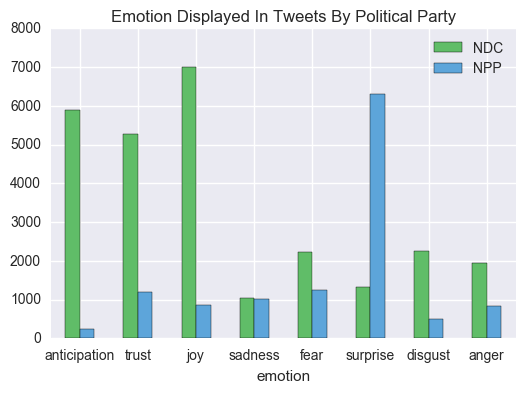

In [70]:
ax = df_party_emotions.plot.bar(x=df_party_emotions['emotion'], 
                           color=['#60BD68', '#5DA5DA'],
                           sharex=True, rot=0,
                           title='Emotion Displayed In Tweets By Political Party',
                          )

In [71]:
ax.set_ylabel("Count")
ax.set_xlabel("Emotion")
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('plots/tweets_emotions_party.png', dpi=200)

### NPP emotions

In [95]:
npp_surprise = npp.sort('score', ascending=False).filter_by('fear', 'emotion').to_dataframe()

In [96]:
npp_surprise[['emotion', 'text', 'permalink']]

,emotion,text,permalink
0,fear,Young people around the country who are actively looking for jobs want change Join them ChooseChange IAmVotingForChange,https://twitter.com/NAkufoAddo/status/802904703889801216
1,fear,Dec 7 is a choice between incompetence mismanagement corruption on one hand visionary leadership on the other hand VoteForChange,https://twitter.com/MBawumia/status/804760913450504192
2,fear,Let s join hands for change and make Ghana work again VoteForChange VoteNanaAddo,https://twitter.com/MBawumia/status/803284771069566976
3,fear,To the Ghanaian who wants an end to excessive government borrowing you have a chance to VoteForChange,https://twitter.com/MBawumia/status/805132378494631936
4,fear,Ghana is indeed at the crossroads And as former President Kufuor said it s time to VoteForChange and hand the country to a competent hand,https://twitter.com/MBawumia/status/805561667241332738
5,fear,Ghana s future depends on your vote VoteAkufoAddo VoteForChange for Ghana to work again for all of us,https://twitter.com/MBawumia/status/804756249661345792
6,fear,Join many Ghanaians that have chosen change ChooseChange I am ReadyForChange YourVoteYourVoice 10Days to change VoteNanaAddo,https://twitter.com/NAkufoAddo/status/802535199078633472
7,fear,Ghanaians want a government that will do a job for them and not a government that will rule with propaganda ChooseChange in 10days,https://twitter.com/NAkufoAddo/status/802536476613316609
8,fear,The 1 Million will be used to finance capital expenditure on upgrading improving infrastructure VoteForChange VoteAkufoAddo,https://twitter.com/MBawumia/status/804622525208625152
9,fear,kalyppo charges ur fon faster than electricity,https://twitter.com/iam_kalypso/status/784890734382030848


### NDC emotions

In [90]:
ndc_surprise = ndc.sort('score', ascending=False).filter_by('anticipation', 'emotion').to_dataframe()
ndc_surprise[['score', 'text', 'permalink']]

,score,text,permalink
0,227,We have decided JMToaso WeHaveDecided,https://twitter.com/GhanaAtWorkGH/status/803227090124316674
1,153,Happy 58th birthday to His Excellency JDMahama Whether you like it or not you are continuing God bless JMTOASO,https://twitter.com/JB5acesports/status/803526471587336192
2,152,Father in the name of Jesus Christ by the Power of your holy spirit bless the good thoughts JDMahama give him another victory JMToaso,https://twitter.com/AbeikuSantana/status/803505724915646464
3,136,We should have our lives back after the elections Vote for peace vote for progress JMToaso,https://twitter.com/Kwamebonfit/status/800641924776468480
4,125,We have retrieved GHc 40million under the National Service scandal and there are still criminal prosecutions ongoing Mahama JMToaso,https://twitter.com/APIIGY/status/800998182327111680
5,121,Emphasis on quality teacher delivery with Science and Mathematics must start from equipping our teacher with the skills JMToaso,https://twitter.com/Kwamebonfit/status/800665904325554176
6,120,Happy birthday Champion wishing you success health and happiness on your birthday You are the best boss in the whole world JMTOASO,https://twitter.com/Samichel4real/status/803539904860921856
7,120,Happy birthday Champion wishing you success health and happiness on your birthday You are the best boss in the whole world JMTOASO,https://twitter.com/Kwamebonfit/status/803542078131240960
8,119,Happy Happy birthday to you Mr President JDMahama You are blessed JMToaso,https://twitter.com/rabisparkle/status/803529173407006720
9,117,To our opponents kalypo isn t vote JMToaso,https://twitter.com/Cytizin_quayson/status/800643228349370368


# Save final tweets data as csv

In [98]:
tweets.save('data/analysed_tweets.csv', format='csv')

In [99]:
tweets.column_names()

['favorites',
 'hashtag',
 'permalink',
 'retweets',
 'score',
 'text',
 'timestamp',
 'username',
 'clean_text',
 'sentiment_score',
 'sentiment',
 'word_count',
 'emotion_score',
 'emotion']